In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import sqlite3

# nbsafety vs nbgather slice result comparison

Author: shreyashankar

This notebook compares the sizes of the slices from nbgather and nbsafety. For each notebook (trace, session pair), we perform the following:

1. Filter out cells in the notebook that cannot be parsed by python's `ast`
2. Isolate the last _line_ of code in the notebook into its own cell
3. Compute dependencies (at the statement level) for the last line in the notebook (note that for nbsafety, we actually have to run the notebook)
4. For nbsafety, verify that the slice, when run, produce the same output as the notebook did
5. For nbgather, verify that the slice can run

Note that for steps 4 and 5, often the output cannot be reproduced (for example, when there is intentional randomness) or the slice cannot be run (for example, when the user forgot to import a library or my computer does not have that library installed or I cannot open a hardedcoded file path).%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [52]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [53]:
# plt.rcParams.update({
#     "font.family": "serif",  # use serif/main font for text elements
#     "text.usetex": True,     # use inline math for ticks
#     "pgf.rcfonts": False,    # don't setup fonts from rc parameters
#     "font.size": 12,
#     "axes.labelsize": "large",
#     "pgf.texsystem": "pdflatex",
#     "pgf.preamble": [
#         r'\usepackage[T1]{fontenc}',
#         r'\usepackage[utf8]{inputenc}',
#         r'\usepackage{amsmath}',
#         r'\usepackage{newtxtext}',
#         r'\usepackage{newtxmath}',
# #         r'\usepackage[lite,subscriptcorrection,slantedGreek,nofontinfo,amsbb,eucal]{mtpro2}'
#     ]
# })
# sns.set_style('ticks')

# plt.figure(figsize=(1,1))
# plt.plot(np.arange(10))

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use('pgf')

## Read files into dataframes

Here is a dictionary of the dataframe we work with:

| Column      | Description |
| ----------- | ----------- |
| `key` | (trace, session) tuple |
| `nbsafety_line_size`      | number of lines in the slice generated by nbsafety       |
| `nbgather_line_size`   | number of lines in the slice generated by nbgather        |
| `exit_status` | exit code produced by a program that runs the nbgather slice (0 for success) |
| `nbsafety_slice_size` | number of cells in the slice generated by nbsafety |
| `nbsafety_reproduced` | boolean indicator whether nbsafety's slice, when run, produces the same output as the original notebook |

In [54]:
# Read nbsafety file
f = open("../stats.txt", "r+")
lines = f.readlines()[1:]
lines = [line[1:-2].split(",") for line in lines]
nbsafety_processed_trace_sessions = {
    (int(line[0].strip()), int(line[1].strip())): (int(line[-3].strip()), int(line[-2].strip()), bool(line[-1].strip()))
    for line in lines
}

program_cells = {
    (int(line[0].strip()), int(line[1].strip())): ",".join(line[2:-4])[2:-1]
    for line in lines
}

In [55]:
conn = sqlite3.connect('../data/traces.sqlite', isolation_level=None)
cursor = conn.cursor()
program_lengths = {}

for k, parsed_cells in program_cells.items():
    TRACE_ID, SESSION_ID = k
    df = pd.read_sql_query(f"SELECT cell_execs.* from cell_execs WHERE trace={TRACE_ID} and session={SESSION_ID} and counter IN ({parsed_cells})", conn)
    lines = [elem for elem in '\n'.join(df['source'].to_list()).split('\n') if elem.strip() != '']
    program_lengths[k] = len(lines)

In [56]:
# Read nbgather file
f = open("../nbgather_stats.txt", "r+")
lines = f.readlines()[1:]
lines = [line[1:-2].split(",") for line in lines]
nbgather_processed_trace_sessions = {
    (int(line[0].strip()), int(line[1].strip())): int(line[2].strip()) for line in lines
}

In [57]:
# Read nbgather successes

f = open("../nbgather_slice_runs.txt", "r+")
lines = f.readlines()[1:]
nbgather_slice_runs = {}

for line in lines:
    filename, status = line.strip().split(',')
    trace = int(filename.split('_')[0])
    session = int(filename.split('_')[1].split('.')[0])
    nbgather_slice_runs[(trace, session)] = int(status)

In [58]:
nbsafety_df = pd.DataFrame({"key": nbsafety_processed_trace_sessions.keys(), "nbsafety_line_size": nbsafety_processed_trace_sessions.values()})
nbgather_df = pd.DataFrame({"key": nbgather_processed_trace_sessions.keys(), "nbgather_line_size": nbgather_processed_trace_sessions.values()})

nbgather_run_df = pd.DataFrame({"key": nbgather_slice_runs.keys(), "exit_status": nbgather_slice_runs.values()})
line_length_df = pd.DataFrame({"key": program_lengths.keys(), "num_lines": program_lengths.values()})

In [59]:
full_df = nbsafety_df.merge(nbgather_df, on=['key'], how='inner').merge(nbgather_run_df, on=['key'], how='inner').merge(line_length_df, on=['key'], how='inner')
full_df[['nbsafety_slice_size', 'nbsafety_line_size', 'nbsafety_reproduced']] = pd.DataFrame(full_df['nbsafety_line_size'].to_list(), index=full_df.index)

In [60]:
full_df['nbgather_line_size'].max()

884

In [64]:
full_df['nbsafety_slice_frac'] = full_df['nbsafety_line_size'] / full_df['num_lines']
full_df['nbgather_slice_frac'] = full_df['nbgather_line_size'] / full_df['num_lines']

## Subset dataframes based on various criteria

In [74]:
# Helpers

def plot_num_lines_histogram(df, filename=None):
    plt.clf()
    plt.grid(linestyle=':')
    bins = np.linspace(0, 1, 50)
    plt.hist(df['nbgather_slice_frac'], bins=bins, alpha=0.3)
    plt.hist(df['nbsafety_slice_frac'], bins=bins, alpha=0.3)
    plt.legend((r'\textrm{\texttt{nbgather}}', r'\textrm{\textsc{nbslicer}}'), loc='upper right')
    plt.xlabel(r"\textrm{Slice size}")
    plt.ylabel(r"\textrm{Count}")
#     plt.title(f"Histogram of number of lines ({len(df)} sessions)")
#     plt.show()
    plt.tight_layout()
    if filename:
        plt.savefig(filename)

def plot_line_diff_histogram(df, filename=None):
    df['diff_frac'] = (df['nbgather_line_size'] - df['nbsafety_line_size']) / df['num_lines']
    df['diff'] = (df['nbgather_line_size'] - df['nbsafety_line_size'])
    df['diff_frac'].hist(bins=100)
    plt.title("Histogram of (nbgather_num_lines - nbsafety_num_lines)")
    plt.show()
    if filename:
        plt.savefig(filename)

In [76]:
plt.clf()
plt.grid(linestyle=':')
plt.hist(full_df['num_lines'], bins=50)
plt.xlabel(r"\textrm{Number of lines}")
plt.ylabel(r"\textrm{Count}")
plt.tight_layout()
plt.savefig("num_lines_hist.pdf")

### No filtering

In [77]:
plot_num_lines_histogram(full_df, "slice_size_hist.pdf")
plot_line_diff_histogram(full_df)
full_df.describe()

<ipython-input-74-5750bc23bcbd>:23: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,nbsafety_line_size,nbgather_line_size,exit_status,num_lines,nbsafety_slice_size,diff_frac,diff,nbsafety_slice_frac,nbgather_slice_frac
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,4.112299,33.248663,0.724599,101.561497,2.350267,0.204592,29.136364,0.099725,0.304317
std,8.710919,99.740036,0.447315,158.254166,2.297635,0.263343,96.265886,0.192328,0.301635
min,1.000000,1.000000,0.000000,1.000000,1.000000,-0.353846,-72.000000,0.000762,0.000762
25%,1.000000,2.000000,0.000000,36.250000,1.000000,0.000000,0.000000,0.018913,0.047009
50%,1.000000,7.000000,1.000000,60.000000,1.000000,0.084770,3.000000,0.040000,0.189640
75%,4.000000,22.000000,1.000000,94.000000,3.000000,0.367982,18.000000,0.080811,0.455295
max,91.000000,884.000000,1.000000,1312.000000,18.000000,0.994898,854.000000,1.000000,1.000000


### Select notebooks where nbgather's slices ran with exit status 0

<ipython-input-23-db401b95027a>:10: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-23-db401b95027a>:18: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,nbsafety_line_size,nbgather_line_size,exit_status,nbsafety_slice_size,diff
count,103.000000,103.000000,103.0,103.000000,103.000000
mean,3.601942,10.902913,0.0,2.582524,1.519955
std,4.792436,25.031946,0.0,2.294598,4.041781
min,1.000000,1.000000,0.0,1.000000,-0.814815
25%,1.000000,1.000000,0.0,1.000000,0.000000
50%,2.000000,2.000000,0.0,2.000000,0.000000
75%,4.000000,6.000000,0.0,3.000000,1.833333
max,27.000000,165.000000,0.0,14.000000,30.000000


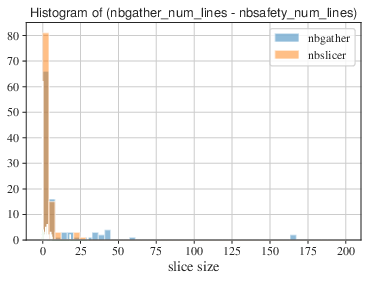

In [25]:
nbgather_ran_df = full_df[full_df['exit_status'] == 0].reset_index(drop=True)
plot_num_lines_histogram(nbgather_ran_df, "nbgather_success_num_lines_hist.pdf")
plot_line_diff_histogram(nbgather_ran_df)
nbgather_ran_df.describe()

### Select notebooks where num lines in slice > 1

<ipython-input-23-db401b95027a>:10: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-23-db401b95027a>:18: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,nbsafety_line_size,nbgather_line_size,exit_status,nbsafety_slice_size,diff
count,185.000000,185.000000,185.000000,185.000000,185.000000
mean,7.291892,49.124324,0.632432,3.729730,4.536048
std,11.563210,139.316814,0.483451,2.629769,6.870406
min,2.000000,1.000000,0.000000,2.000000,-0.814815
25%,2.000000,4.000000,0.000000,2.000000,0.000000
50%,4.000000,13.000000,1.000000,3.000000,1.636364
75%,7.000000,37.000000,1.000000,4.000000,6.000000
max,91.000000,1013.000000,1.000000,18.000000,34.000000


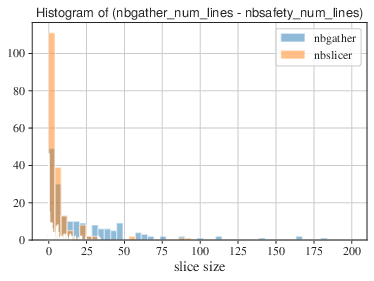

In [26]:
large_slice_df = full_df[full_df['nbsafety_slice_size'] > 1].reset_index(drop=True)
plot_num_lines_histogram(large_slice_df, "large_slice_num_lines_hist.pdf")
plot_line_diff_histogram(large_slice_df)
large_slice_df.describe()

### Select notebooks where nbgather's slices ran with exit status 0 and num lines in slice > 1

<ipython-input-23-db401b95027a>:10: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-23-db401b95027a>:18: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,nbsafety_line_size,nbgather_line_size,exit_status,nbsafety_slice_size,diff
count,68.000000,68.000000,68.0,68.000000,68.000000
mean,4.941176,14.838235,0.0,3.397059,1.140519
std,5.441363,29.772576,0.0,2.456424,1.782063
min,2.000000,2.000000,0.0,2.000000,-0.814815
25%,2.000000,2.000000,0.0,2.000000,0.000000
50%,3.000000,4.000000,0.0,2.000000,0.000000
75%,5.000000,11.500000,0.0,4.000000,2.050000
max,27.000000,165.000000,0.0,14.000000,5.875000


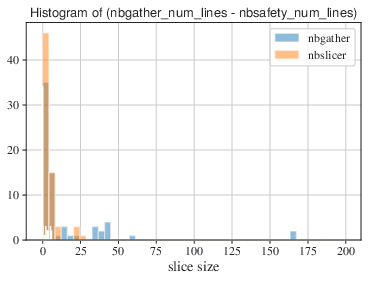

In [27]:
large_slice_successful_run_df = full_df[(full_df['nbsafety_slice_size'] > 1) & (full_df['exit_status'] == 0)].reset_index(drop=True)
plot_num_lines_histogram(large_slice_successful_run_df, "both_cond_num_lines_hist.pdf")
plot_line_diff_histogram(large_slice_successful_run_df)
large_slice_successful_run_df.describe()